In [1]:
import os, shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import kagglehub


In [9]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Dataset path:", path)
data_root = os.path.join(path, "garbage classification", "Garbage classification")

transform_clean = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Add Gaussian Noise
class AddNoise(object):
    def __call__(self, tensor):
        noise = torch.randn_like(tensor) * 0.2
        tensor = tensor + noise
        return torch.clamp(tensor, 0., 1.)

# Add Gaussian Blur
class AddBlur(object):
    def __call__(self, img):
        blur = transforms.GaussianBlur(kernel_size=5, sigma=2.0)
        return blur(img)

transform_corrupt = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    AddNoise(),
])

# One loader with noisy
noisy_dataset = datasets.ImageFolder(root=data_root, transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    AddNoise()
]))

# One loader with blurred
blurred_dataset = datasets.ImageFolder(root=data_root, transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Lambda(lambda img: AddBlur()(img)),
    transforms.ToTensor()
]))

# Clean dataset
clean_dataset = datasets.ImageFolder(root=data_root, transform=transform_clean)

# Combine noisy + blurred datasets
combined_data = torch.utils.data.ConcatDataset([noisy_dataset, blurred_dataset])
clean_data    = torch.utils.data.ConcatDataset([clean_dataset, clean_dataset])

# Dataloaders
corrupt_loader = DataLoader(combined_data, batch_size=64, shuffle=True)
clean_loader   = DataLoader(clean_data, batch_size=64, shuffle=False)

print("Dataset size:", len(clean_dataset))
print("Classes:", clean_dataset.classes)


Dataset path: /kaggle/input/garbage-classification
Dataset size: 2527
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    for (corrupt_imgs, _), (clean_imgs, _) in zip(corrupt_loader, clean_loader):
        corrupt_imgs, clean_imgs = corrupt_imgs.to(device), clean_imgs.to(device)

        outputs = model(corrupt_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():.4f}")


Using device: cuda
Epoch [1/10] | Loss: 0.0365
Epoch [2/10] | Loss: 0.0366
Epoch [3/10] | Loss: 0.0350
Epoch [4/10] | Loss: 0.0345
Epoch [5/10] | Loss: 0.0344
Epoch [6/10] | Loss: 0.0349
Epoch [7/10] | Loss: 0.0345
Epoch [8/10] | Loss: 0.0345
Epoch [9/10] | Loss: 0.0346
Epoch [10/10] | Loss: 0.0343


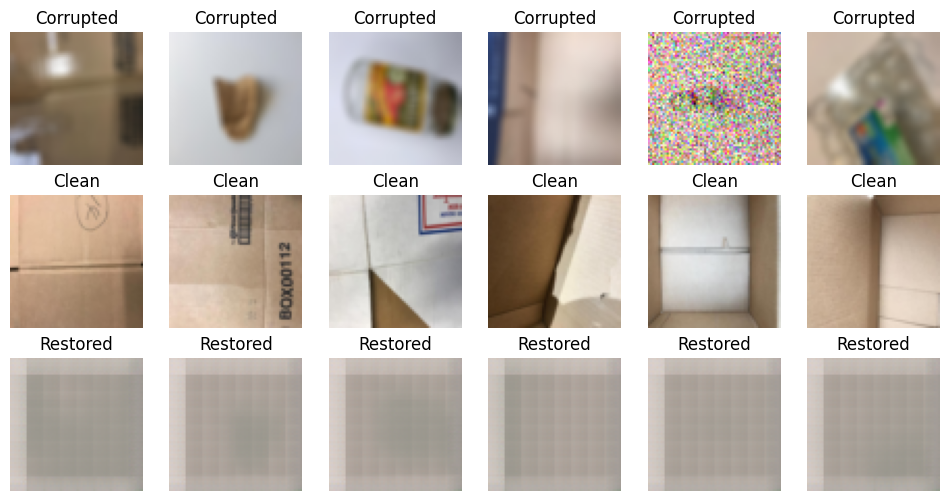

In [8]:
import numpy as np
corrupt_imgs, _ = next(iter(corrupt_loader))
clean_imgs, _   = next(iter(clean_loader))
corrupt_imgs, clean_imgs = corrupt_imgs.to(device), clean_imgs.to(device)

# Reconstruct
with torch.no_grad():
    outputs = model(corrupt_imgs)

# Show comparison
def show_images(corrupt, clean, reconstructed, n=6):
    plt.figure(figsize=(12,6))
    for i in range(n):
        # Corrupted
        plt.subplot(3,n,i+1)
        plt.imshow(np.transpose(corrupt[i].cpu(), (1,2,0)))
        plt.title("Corrupted")
        plt.axis("off")

        # Clean
        plt.subplot(3,n,i+1+n)
        plt.imshow(np.transpose(clean[i].cpu(), (1,2,0)))
        plt.title("Clean")
        plt.axis("off")

        # Denoised
        plt.subplot(3,n,i+1+2*n)
        plt.imshow(np.transpose(reconstructed[i].cpu(), (1,2,0)))
        plt.title("Restored")
        plt.axis("off")

    plt.show()

show_images(corrupt_imgs, clean_imgs, outputs)
